# Impulse Response and Convolution

An impulse is just an image consisting of all zeros, except for a single pixel that has the value 1.0, at the center.
Impulse responses fully characterize linear filters, as we shall see below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as img
from PIL import Image

In [2]:
def imrow(*args):
    _, axs = plt.subplots(1,len(args))
    for i, im in enumerate(args):
        axs[i].imshow(im, cmap='gray')

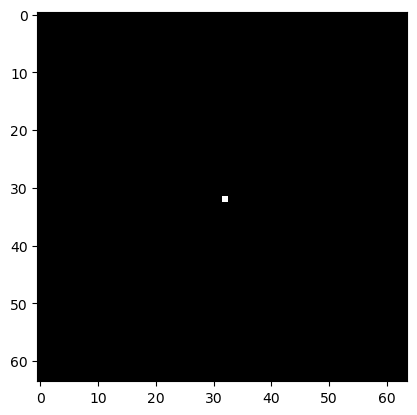

In [3]:
# 2D array representing an impulse
impulse = np.zeros((64,64))
impulse[32,32] = 1.0
plt.imshow(impulse,  cmap='gray')

## Box Filter and Gaussian Filter

Let's start by loading an image and inspecting it. We are looking at a grayscale image

(300, 400, 3) [[[175 175 175]]] 255


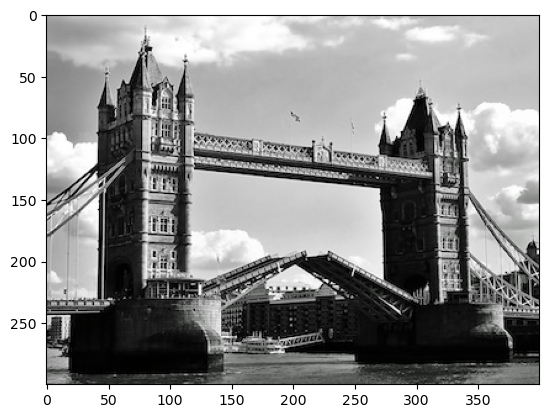

In [4]:
image = np.array(Image.open('images/bridge.jpeg'))
print(image.shape, image[:1,:1,:], np.max(image))
plt.imshow(image)

(300, 400) [[0.68627451]] 1.0


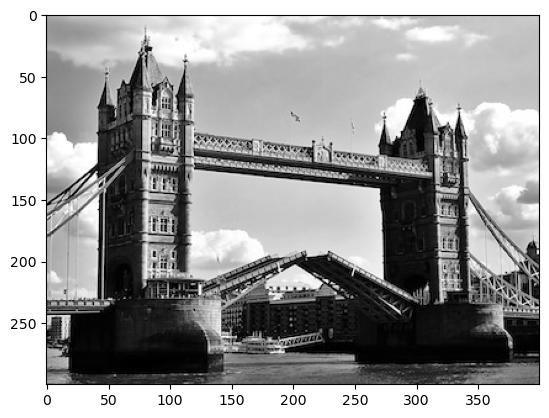

In [5]:
flatten = np.average(image, axis=2) / 255.0
print(flatten.shape, flatten[:1,:1], np.max(flatten))
plt.imshow(flatten, cmap='gray')

Let's start with a box filter (or uniform filter).
You can think of this as "local averaging" of the pixels of an image.
That is, you replace each pixel with an average of the pixels around it.

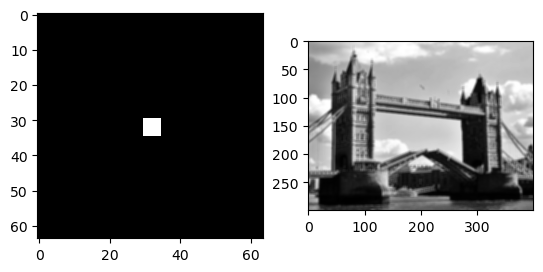

In [6]:
imrow(img.uniform_filter(impulse, 5.0), img.uniform_filter(flatten, 5.0))

Can you spot what is happening? We are averaging over the image. The filter's response can be seen very clearly on the impulse image. 

In the next stepp, we use a different filter, than just a stupid box filter. We use a gaussian filter.

A Gaussian filter is similar to a box filter, but instead of taking an average
over a neighborhood, you take a weighted average.
The further a pixel is away from the center pixel, the less it contributes to the average.
The weight of the averages is given by the Gaussian function (see below).
Using it has numerous mathematical and practical advantages.
This is one of the most common filters used in practice.
You can "read off" the weights in the impulse response.

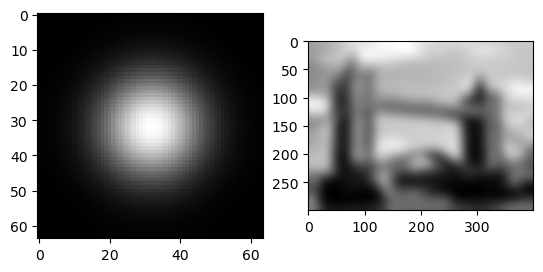

In [7]:
imrow(img.gaussian_filter(impulse, 10.0), img.gaussian_filter(flatten, 10.0))

The impulse response is important because it completely characterizes a linear shift invariant filter.
Why?  Because we can decompose an image into impulses, then apply the impulse response to each filter,
and then add it all up again.

(definitions)

Let the input image be $I$ and pixel $(i,j)$ given by $I_{ij}$.

Write the impulse signal as $\delta$.

Also, let $S_{ij}$ be a filter that shifts 
the image such that the pixel at the origin ends
up at position $i,j$.
It's easy to see that $S$ is also a linear filter.

Now,

$ I = \sum S_{ij}[I_{ij}\cdot\delta] $

(impulse response and filters)

$ F[I] = F[\sum S_{ij}[I_{ij}\delta]] $

By linearity:

$ = \sum F[S_{i,j} [I_{ij}\delta]] $

By shift invariance:

$ = \sum S_{i,j}[ F[I_{ij}\delta] ] $ 

By linearity, since $I_{ij}$ is just a number:

$ = \sum S_{i,j} [I_{ij} F[\delta] ] $

Here, $F[\delta]$ is the impulse response.

(equivalence)

Therefore, applying a linear filter is equivalent to 
just summing up its impulse response.

(convolution)

The operation of combining an image with the impulse response of a filter is called the _convolution_.

Ignoring boundary conditions, for infinitely large 1D signals, it is written as:

$ (x * y)~_i = \sum_{j=-\infty}^{\infty} x_j y_{i-j} $

(properties of convolutions)

Convolution has the following properties:

- commutativity: $x * y = y * x$
- associativity: $x * (y * z) = (x * y) * z$
- distributivity: $x * (y + z) = x * y + x * z$
- scalar multiplication: $\alpha (x * y) = (\alpha x) * y = x * (\alpha y)$

(2D convolution)

In 2D, convolution is defined analogously.

These properties carry over to linear shift invariant filters, since convolutions and linear
shift invariant filters are equivalent.


(cross-correlation)

Note that there is a closely related operation where the minus sign has been replaced with a plus, the _cross-correlation_:

$ (x \star y)~_i = \sum_{j=-\infty}^{\infty} x_j y_{i+j} $

The minus sign has the effect of "flipping" the mask around. 
This is also a useful operation, but the algebraic identities above don't quite hold anymore.

(convolution in the library)

Convolution is implemented by the `convolve` function.

Let us check that applying linear filter $g(\cdot,5)$ is the same as convolving with its impulse response.

That is, $g(x,5) = x * g(\delta,5)$

In [8]:
mask = img.gaussian_filter(impulse, 5.0)
convolved_image = img.convolve(flatten, mask)
filtered_image = img.gaussian_filter(flatten, 5.0)

imrow(convolved_image, filtered_image)
print(np.amax(abs(filtered_image-convolved_image)))

# Composition of Filters

Let us check associativity of filters.
This is a very useful property of linear filters because instead of applying a sequence
of tilers, we can pre-compose the filters and then just apply the filter once.

2.9170629032293505e-06


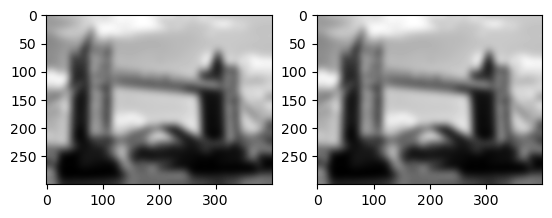

In [ ]:
# composition of linear filters
result1 = img.convolve(img.convolve(flatten,mask),mask)
result2 = img.convolve(flatten,img.convolve(mask,mask))
imrow(result1,result2)
print(np.amax(abs(result1-result2)))

(composition of Gaussian filters)

Does this work for Gaussian filters?

Yes, but there is one small thing to watch out for: 
the parameter that we give to the Gaussian filter does not
quite combine in the way we expect.
Applying two Gaussian filters of width 5 is
equivalent to applying on one of width $\sqrt{5^2+5^2}$.

(Looking at the definition of the Gaussian and Gaussian filter below,
work out for yourself why these parameters behave like that.)

3.710844170035088e-05


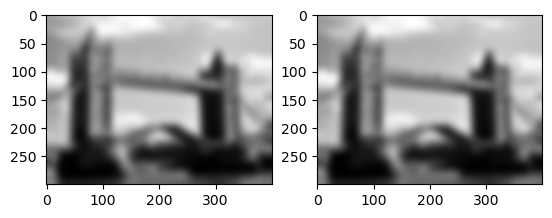

In [ ]:
gf = img.gaussian_filter
result1 = gf(gf(flatten,5.0),5.0)
result2 = gf(flatten,np.sqrt(5**2+5**2))
imrow(result1,result2)
print(np.amax(abs(result1-result2)))

# Separability

Many filtes are separable.  That is, instead of convolving with a 2D mask, we can convolve with
two 1D masks.

For Gaussian filters, we can actually specify the width and the height of the filter separately.
Applying two filters of shape (5,0) and (0,5) is equivalent to applying one filter
of shape (5,5).

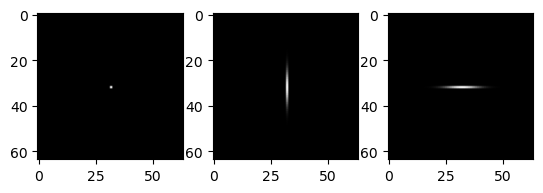

In [ ]:
# horizontal and vertical Gaussians
vf = gf(impulse,(5.0,0.0))
hf = gf(impulse,(0.0,5.0))
imrow(impulse, vf,hf)

The convolution of these two filters is the same as a Gaussian.

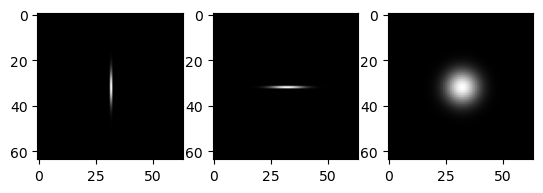

In [ ]:
# convolution of horizontal and vertical Gaussians
imrow(vf,hf,img.convolve(vf,hf))

These properties now carry over to the filters themselves. 

Note that $ g(\cdot,(5,0)) $ is implemented more efficiently than $g(\cdot,(5,5))$.

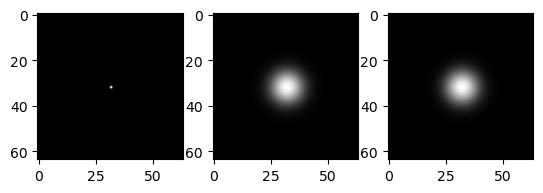

In [ ]:
# separable convolution
imrow(impulse,gf(impulse,(5.0,5.0)),gf(gf(impulse,(5.0,0.0)),(0.0,5.0)))

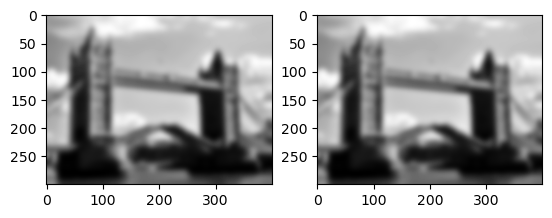

In [ ]:
# separable convolution
imrow(gf(flatten,(5.0,5.0)),gf(gf(flatten,(5.0,0.0)),(0.0,5.0)))

# Gaussians

We keep talking about Gaussian filters, but haven't really looked at what those weights are.

They are given by the following simple function.

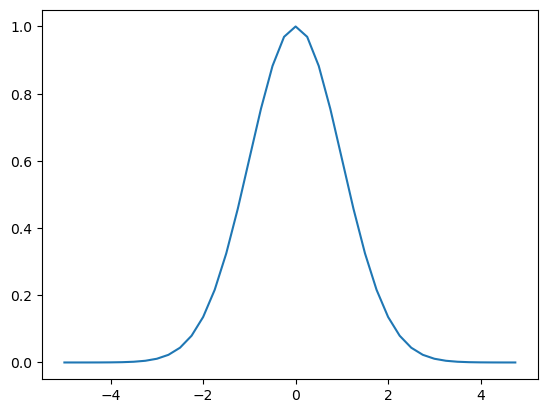

In [ ]:
xs = np.arange(-5.0,5.0,0.25)
ys = np.exp(-xs**2/2.0)
plt.plot(xs,ys)


The general formula is:

$ G(x) = (2\pi\sigma^2)^{-1/2} e^\frac{-(x-\mu)^2}{2\sigma^2} $

This generalizes to multiple dimensions by just using vectors for $\mu$ and $x$.

For 2D filtering, we compute the outer product of these 1D masks. 
This is analogous to the convolution of the horizontal and vertical masks
above, where we looked at separability.

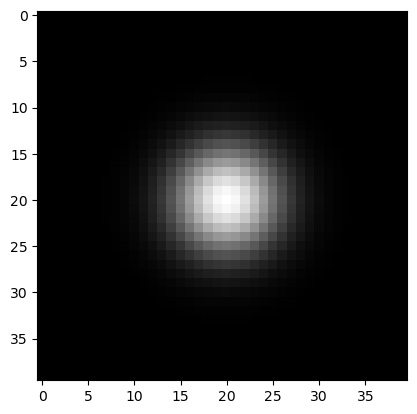

In [ ]:
mask = np.outer(ys,ys)
plt.imshow(mask, cmap='gray')

Now let's just look at how this filter looks.

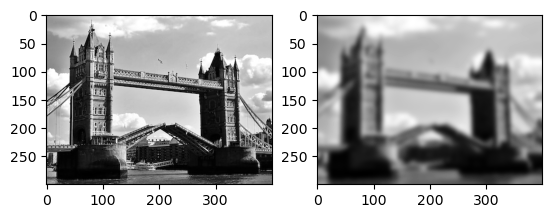

In [ ]:
# convolution with an explicitly constructed Gaussian mask
imrow(flatten,img.convolve(flatten,mask))

# Data Parallel Convolution

Above, we had already talked about linear filters as kinds of local averaging operations.

A simple implementation of this is to actually compute local averages.   Here is Python
code that does this.

In [ ]:
# nested loop implementation of a box filter
def dumb_boxfilter(image,r):
    r /= 2
    w,h = image.shape
    out = np.zeros(image.shape)
    r = int(r)
    for i in range(r,w-r):
        for j in range(r,h-r):
            out[i,j] = np.mean(image[i-r:i+r,j-r:j+r])
    return out

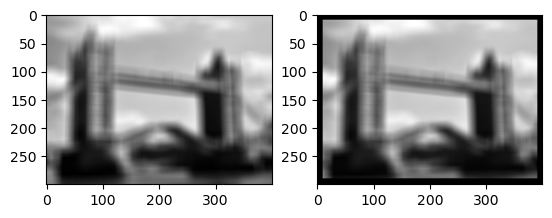

In [ ]:
# library vs nested loop for box filter
imrow(img.uniform_filter(flatten,20),dumb_boxfilter(flatten,20))

This turns out not to be a very efficient way of implementing these kinds of filters in array
languages, because there are lots of loop steps and local operations.

It is much more efficient to loop over the $r$ values and leave the addition of the big
arrays to fast array operations within Python.

First let's look at the library function roll:

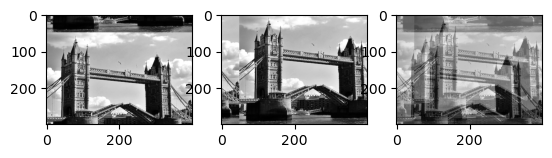

In [ ]:
a = np.roll(flatten, 50, axis=0)
b = np.roll(flatten, 50, axis=1)
c = a+b
imrow(a, b, c/np.amax(c))

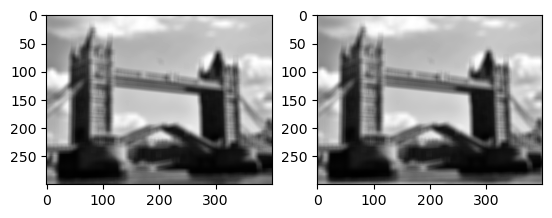

In [ ]:
# data parallel implementation of box filter
def simple_average(image,r):
    out = np.zeros(image.shape)
    r_ = int(r/2)
    for i in range(-r_,r_):
        for j in range(-r_,r_):
            out += np.roll(np.roll(image,i,axis=0),j,axis=1)
    return out*1.0/(r*r)

imrow(img.uniform_filter(flatten,10),simple_average(flatten,10))

We can also implement general convolutions with masks by computing a weighted average/sum.

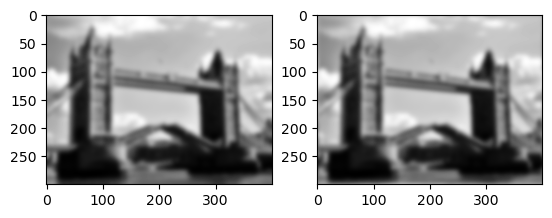

In [ ]:
# data parallel implementation of convolution
def simple_convolve(image, mask):
    mw, mh = mask.shape
    out = np.zeros(image.shape)
    for i in range(mw):
        for j in range(mh):
            out += mask[i, j]*np.roll(np.roll(image,
                                      int(mw/2-i), axis=0), int(mh/2-j), axis=1)
    return out

imrow(img.convolve(flatten,mask), simple_convolve(flatten,mask))
